In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
import glob

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense, Reshape, LeakyReLU, Conv2DTranspose
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.io.gfile import GFile
from tensorflow.strings import unicode_split
from tensorflow.data import Dataset

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
class DataManager():    
    def __init__(self, file_path):
        self.file_path = file_path
        self.ids_to_chars_layer = None
    
    def decode_text(self, ids):
        if self.ids_to_chars_layer is None:
            return None

        return tf.strings.reduce_join(self.ids_to_chars_layer(ids), axis=-1)
    
    def parse_img(self, file_name):
        img = tf.io.read_file(file_name)
        img = tf.io.decode_png(img, channels=3)
        img = tf.image.resize(img, [224, 224], antialias=True, method='nearest')
        img = tf.cast(img, tf.float32) / 255.0
        
        return img

    def get_img_ds(self):
        file_names = glob.glob('datasets/imgs/*')
        img_ds = Dataset.from_tensor_slices(file_names)
        img_ds = img_ds.map(self.parse_img, num_parallel_calls=tf.data.AUTOTUNE)
        img_ds = img_ds.batch(C.BATCH_SIZE)
        
        return img_ds
    

    def get_svg_ds(self):
        data = GFile('datasets/svgs/simpleline.svg', 'rb').read().decode(encoding='UTF-8')
        
        # Get the list of the unique characters in the text
        vocab = ['e', 'g', 'n', 'r', '\n']
        vocab_size = len(vocab)
        
        # Build the id to char lookup table
        chars_to_ids = StringLookup(vocabulary=vocab)
        self.ids_to_chars_layer = StringLookup(vocabulary=chars_to_ids.get_vocabulary(), invert=True)

        # Split the entire text by character
        chars = unicode_split(data, 'UTF-8')
        ids_of_chars = chars_to_ids(chars)
        
        # Group characters to form sequences
        svg_ds = Dataset.from_tensor_slices(ids_of_chars)
        svg_ds = svg_ds.batch(C.SEQUENCE_LENGTH)
        svg_ds = svg_ds.batch(C.BATCH_SIZE)
        
        return svg_ds

    def load_data(self):
        img_ds = self.get_img_ds()
        svg_ds = self.get_svg_ds()

        # Batch the sequences
        ds = Dataset.zip((svg_ds, img_ds))
        ds = ds.shuffle(C.BUFFER_SIZE)
        ds = ds.prefetch(tf.data.experimental.AUTOTUNE)

        return ds
    
    def to_inputs_and_targets(self, sequences):
        # Exclude the last character
        inputs = sequences[:, :-1] # H e l l o -> H e l l
        # Exclude the first character
        targets = sequences[:, 1:] # H e l l o -> e l l o
        return inputs, targets

In [8]:
class TrainManager():
    def __init__(self):
        self.model = None
        self.dataset = None
        self.data_manager = DataManager(C.DATA_PATH)
        
    def load_data(self):
        self.dataset = self.data_manager.load_data()
    
    def load_model(self):
        self.model = Sequential()
        self.model.add(Embedding(input_dim=C.VOCAB_SIZE, output_dim=C.EMBEDDING_DIM))
        self.model.add(SimpleRNN(128))
        
        # 7x7
        self.model.add(Dense(128 * 7 * 7))
        self.model.add(LeakyReLU(alpha=0.02))
        self.model.add(Reshape((7, 7, 128)))
        # 14x14
        self.model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
        self.model.add(LeakyReLU(alpha=0.02))
        # 28x28
        self.model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
        self.model.add(LeakyReLU(alpha=0.02))
        # 56x56
        self.model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
        self.model.add(LeakyReLU(alpha=0.02))
        # 112x112
        self.model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
        self.model.add(LeakyReLU(alpha=0.02))
        # 224x224
        self.model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
        self.model.add(LeakyReLU(alpha=0.02))
        # Final image
        self.model.add(tf.keras.layers.Conv2D(3, (7, 7), activation='sigmoid', padding='same'))

        self.model.compile(
            optimizer=Adam(lr=C.INITIAL_LR),
            loss=tf.keras.losses.MeanSquaredError()
        )
        
    def sample_text(self):
        preds = self.model.predict(self.dataset)

        print('preds shape', preds.shape)

        sampled_indices = tf.random.categorical(preds[0], num_samples=1)
        sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
        pred_text = self.data_manager.decode_text(sampled_indices)

        print('pred', pred_text.numpy())
        
    def train(self):
        if self.model is None:
            self.load_model()
            
        if self.dataset is None:
            self.load_data()
            
        self.model.fit(self.dataset, epochs=C.EPOCHS)

In [13]:
class C:
    # --- DATA --- #
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 8
    VOCAB_SIZE = 67
    EMBEDDING_DIM = 56
    BUFFER_SIZE = 10000
    DATA_PATH = 'datasets/simpleline.svg'
    
    # -- TRAINING -- #
    EPOCHS = 50
    INITIAL_LR = 1e-02

tm = TrainManager()

# tm.load_model()
tm.train()

Epoch 1/50
1/1 [==============================] - 1s 786ms/step - loss: 0.2500
Epoch 2/50
1/1 [==============================] - 0s 60ms/step - loss: 0.2191
Epoch 3/50
1/1 [==============================] - 0s 61ms/step - loss: 0.0396
Epoch 4/50
1/1 [==============================] - 0s 61ms/step - loss: 0.0065
Epoch 5/50
1/1 [==============================] - 0s 61ms/step - loss: 0.0065
Epoch 6/50
1/1 [==============================] - 0s 58ms/step - loss: 0.0066
Epoch 7/50
1/1 [==============================] - 0s 61ms/step - loss: 0.0066
Epoch 8/50
1/1 [==============================] - 0s 59ms/step - loss: 0.0066
Epoch 9/50
1/1 [==============================] - 0s 60ms/step - loss: 0.0066
Epoch 10/50
1/1 [==============================] - 0s 60ms/step - loss: 0.0066
Epoch 11/50
1/1 [==============================] - 0s 58ms/step - loss: 0.0066
Epoch 12/50
1/1 [==============================] - 0s 60ms/step - loss: 0.0066
Epoch 13/50
1/1 [==============================] - 0s 59ms/s

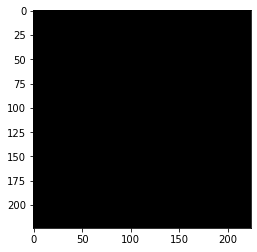

In [14]:
preds = tm.model.predict(next(iter(tm.dataset))[0])

plt.imshow(preds[0])

In [49]:
tm.model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 56)           3752      
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 128)               23680     
_________________________________________________________________
dense_14 (Dense)             (None, 6272)              809088    
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 6272)              0         
_________________________________________________________________
reshape_10 (Reshape)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 14, 14, 128)     

In [67]:
tttt = DataManager('dsa')
myds = tttt.load_data()

next(iter(myds))

(<tf.Tensor: shape=(1, 6), dtype=int64, numpy=array([[3, 5, 2, 2, 4, 6]])>,
 <tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
 array([[[[0., 1., 0.],
          [0., 1., 0.],
          [0., 1., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 1., 0.],
          [0., 1., 0.],
          [0., 1., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 1., 0.],
          [0., 1., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 1., 0.],
          [0., 1., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 1., 0.],
          [0., 1., 0.],
          [0., 1., 0.]],
 
         [[0., 0., 0.],
          [0., 